In [1]:
import numpy as np
import librosa
import os
import random
import tflearn
import tensorflow as tf

/Users/i346047/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/i346047/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
lr = 0.001
iterations_train = 30
bsize = 64
audio_features = 20  
utterance_length = 35  
ndigits = 10 

In [3]:
def get_mfcc_features(fpath):
    raw_w,sampling_rate = librosa.load(fpath,mono=True)
    mfcc_features = librosa.feature.mfcc(raw_w,sampling_rate)
    if(mfcc_features.shape[1]>utterance_length):
        mfcc_features = mfcc_features[:,0:utterance_length]
    else:
        mfcc_features=np.pad(mfcc_features,((0,0),(0,utterance_length-mfcc_features.shape[1])), 
                             mode='constant', constant_values=0)
    return mfcc_features

Feature shape:  (20, 35)
Features:  [-5.16464322e+02  2.18720111e+02 -9.43628435e+01  1.63510496e+01
  2.09937445e+01 -4.38791200e+01  1.94267052e+01 -9.41531735e-02
 -2.99960992e+01  1.39727129e+01  6.60561909e-01 -1.14758965e+01
  3.13688180e+00 -1.34556070e+01 -1.43686686e+00  1.17119580e+01
 -1.54499037e+01 -1.13105764e+01  2.53027299e+00 -1.35725427e+01]


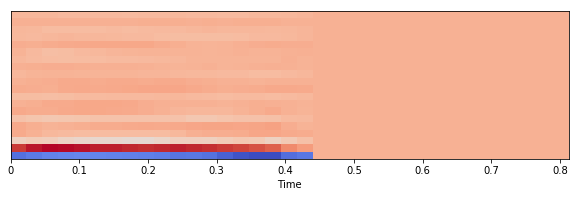

In [4]:
import matplotlib.pyplot as plt
import librosa.display
%matplotlib inline
mfcc_features = get_mfcc_features('../../speech_dset/recordings/train/5_theo_45.wav')
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
librosa.display.specshow(mfcc_features, x_axis='time')
print("Feature shape: ", mfcc_features.shape)
print("Features: ", mfcc_features[:,0])

In [5]:
def get_batch_mfcc(fpath,batch_size=256):
    ft_batch = []
    labels_batch = []
    files = os.listdir(fpath)
    while True:
        print("Total %d files" % len(files))
        random.shuffle(files)
        for fname in files:
            if not fname.endswith(".wav"): 
                continue
            mfcc_features = get_mfcc_features(fpath+fname)  
            label = np.eye(10)[int(fname[0])]
            labels_batch.append(label)
            ft_batch.append(mfcc_features)
            if len(ft_batch) >= batch_size:
                yield ft_batch, labels_batch 
                ft_batch = []  
                labels_batch = []

In [6]:
train_batch = get_batch_mfcc('../../speech_dset/recordings/train/')
sp_network = tflearn.input_data([None, audio_features, utterance_length])
sp_network = tflearn.lstm(sp_network, 128*4, dropout=0.5)
sp_network = tflearn.fully_connected(sp_network, ndigits, activation='softmax')
sp_network = tflearn.regression(sp_network, optimizer='adam', learning_rate=lr, loss='categorical_crossentropy')
sp_model = tflearn.DNN(sp_network, tensorboard_verbose=0)
while iterations_train > 0:
    X_tr, y_tr = next(train_batch)
    X_test, y_test = next(train_batch)
    sp_model.fit(X_tr, y_tr, n_epoch=10, validation_set=(X_test, y_test), show_metric=True, batch_size=bsize)
    iterations_train-=1
sp_model.save("/tmp/speech_recognition.lstm")

Training Step: 1199  | total loss: 0.45749 | time: 0.617s
| Adam | epoch: 300 | loss: 0.45749 - acc: 0.8975 -- iter: 192/256
Training Step: 1200  | total loss: 0.43931 | time: 1.819s
| Adam | epoch: 300 | loss: 0.43931 - acc: 0.9031 | val_loss: 0.18600 - val_acc: 0.9375 -- iter: 256/256
--
INFO:tensorflow:/tmp/speech_recognition.lstm is not in all_model_checkpoint_paths. Manually adding it.


In [7]:
sp_model.load('/tmp/speech_recognition.lstm')
mfcc_features = get_mfcc_features('../../speech_dset/recordings/test/4_jackson_40.wav')
mfcc_features = mfcc_features.reshape((1,mfcc_features.shape[0],mfcc_features.shape[1]))
prediction_digit = sp_model.predict(mfcc_features)
print(prediction_digit)
print("Digit predicted: ", np.argmax(prediction_digit))

INFO:tensorflow:Restoring parameters from /tmp/speech_recognition.lstm
[[2.3709694e-03 5.1581711e-03 7.8898791e-04 1.9530311e-03 9.8459840e-01
  1.1394228e-03 3.0317350e-04 1.8992715e-03 1.6027489e-03 1.8592674e-04]]
Digit predicted:  4
